# ECOFLY PART 1: DESCRIPTIVE ANALYSIS

### 1.1. Descriptive Exploration

Please find a link to our datasets here: https://lsecloud-my.sharepoint.com/:f:/g/personal/v_r_laugeri_lse_ac_uk/EsZ2JZyU7CBPiSiUbYSACuMBw9NC-BK3CjtLY87LRF3qIg?e=yfSCle
(Note that you will need an LSE username in OneDrive to access this)

In [43]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, TimestampType, LongType, DoubleType


schema = StructType([
    StructField("Departure Airport Code", StringType(), True), 
    StructField("Departure Country", StringType(), True), 
    StructField("Arrival Airport Code", StringType(), True), 
    StructField("Arrival Country", StringType(), True), 
    StructField("Aircraft Type", StringType(), True), 
    StructField("Airline Number", StringType(), True), 
    StructField("Airline Name", StringType(), True), 
    StructField("Flight Number", StringType(), True), 
    StructField("Departure Time", TimestampType(), True), 
    StructField("Arrival Time", TimestampType(), True), 
    StructField("Duration", LongType(), True), 
    StructField("Stops", LongType(), True), 
    StructField("Price", StringType(), True), 
    StructField("Currency", StringType(), True), 
    StructField("Actual CO2 Emissions", DoubleType(), True), 
    StructField("Average CO2 Emissions", DoubleType(), True), 
    StructField("CO2 % Difference", StringType(), True),
    StructField("Scan Date", TimestampType(), True)
])

In [44]:
# creating the path for the data
flights_path = "gs://selected-flights-bucket/selected_flights.csv"

flight_data = spark.read.csv(flights_path, header=True, schema=schema)
flight_data.show(10)

+----------------------+-----------------+--------------------+---------------+--------------------+--------------+--------------------+--------------------+-------------------+-------------------+--------+-----+------+--------+--------------------+---------------------+----------------+-------------------+
|Departure Airport Code|Departure Country|Arrival Airport Code|Arrival Country|       Aircraft Type|Airline Number|        Airline Name|       Flight Number|     Departure Time|       Arrival Time|Duration|Stops| Price|Currency|Actual CO2 Emissions|Average CO2 Emissions|CO2 % Difference|          Scan Date|
+----------------------+-----------------+--------------------+---------------+--------------------+--------------+--------------------+--------------------+-------------------+-------------------+--------+-----+------+--------+--------------------+---------------------+----------------+-------------------+
|                   ALG|          Algeria|                 SYD|      Aust

In [4]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf

# Defining a user-defined function (UDF) to remove non-numeric characters and convert to integer
def convert_int(value):
    if value is not None:
        value = value.split(".")[0]  # Take only the part before the decimal point
        value = ''.join(filter(str.isdigit, value))  # Remove non-numeric characters
        return int(value) if value else None
    else:
        return None

# Registering the UDFs
convert_int_udf = udf(convert_int, IntegerType())

# Applying the UDFs to the specified columns
col_to_int = ["Price", "Actual CO2 Emissions", "Average CO2 Emissions", "CO2 % Difference"]

for col_name in col_to_int:
    flight_data = flight_data.withColumn(col_name, convert_int_udf(col(col_name)))

# Showing outcome with new specs
flight_data.printSchema()

root
 |-- Departure Airport Code: string (nullable = true)
 |-- Departure Country: string (nullable = true)
 |-- Arrival Airport Code: string (nullable = true)
 |-- Arrival Country: string (nullable = true)
 |-- Aircraft Type: string (nullable = true)
 |-- Airline Number: string (nullable = true)
 |-- Airline Name: string (nullable = true)
 |-- Flight Number: string (nullable = true)
 |-- Departure Time: timestamp (nullable = true)
 |-- Arrival Time: timestamp (nullable = true)
 |-- Duration: long (nullable = true)
 |-- Stops: long (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Actual CO2 Emissions: integer (nullable = true)
 |-- Average CO2 Emissions: integer (nullable = true)
 |-- CO2 % Difference: integer (nullable = true)
 |-- Scan Date: timestamp (nullable = true)



In [5]:
flight_data.show(10)

+----------------------+-----------------+--------------------+---------------+--------------------+--------------+--------------------+--------------------+-------------------+-------------------+--------+-----+-----+--------+--------------------+---------------------+----------------+-------------------+
|Departure Airport Code|Departure Country|Arrival Airport Code|Arrival Country|       Aircraft Type|Airline Number|        Airline Name|       Flight Number|     Departure Time|       Arrival Time|Duration|Stops|Price|Currency|Actual CO2 Emissions|Average CO2 Emissions|CO2 % Difference|          Scan Date|
+----------------------+-----------------+--------------------+---------------+--------------------+--------------+--------------------+--------------------+-------------------+-------------------+--------+-----+-----+--------+--------------------+---------------------+----------------+-------------------+
|                   ALG|          Algeria|                 SYD|      Austral

#### 1.1.1 Null Variables

In [6]:
from pyspark.sql.functions import col

# Creating a dict. to store null sums for each column
null_counts = {}

# Iterating in the DataFrame
for col_name in flight_data.columns:
    # Count the number of null values in the current column
    null_count = flight_data.filter(col(col_name).isNull()).count()
    # Store the null count in the dictionary
    null_counts[col_name] = null_count

# Print the null counts for each column
for col_name, count in null_counts.items():
    print(f"Number of null values in '{col_name}': {count}")

Number of null values in 'Departure Airport Code': 0
Number of null values in 'Departure Country': 0
Number of null values in 'Arrival Airport Code': 0
Number of null values in 'Arrival Country': 0
Number of null values in 'Aircraft Type': 4722
Number of null values in 'Airline Number': 0
Number of null values in 'Airline Name': 0
Number of null values in 'Flight Number': 0
Number of null values in 'Departure Time': 0
Number of null values in 'Arrival Time': 0
Number of null values in 'Duration': 0
Number of null values in 'Stops': 0
Number of null values in 'Price': 310
Number of null values in 'Currency': 0
Number of null values in 'Actual CO2 Emissions': 1406
Number of null values in 'Average CO2 Emissions': 8371
Number of null values in 'CO2 % Difference': 9698
Number of null values in 'Scan Date': 0


### 1.2. Create RDD

In [7]:
flights_rdd = flight_data.rdd

In [8]:
for row in flights_rdd.take(5):
    print(row)

Row(Departure Airport Code='ALG', Departure Country='Algeria', Arrival Airport Code='SYD', Arrival Country='Australia', Aircraft Type='Airbus A330|Boeing 777|Airbus A330', Airline Number='multi', Airline Name='[Turkish Airlines| Malaysia Airlines]', Flight Number='TK652|TK652|TK652', Departure Time=datetime.datetime(2022, 4, 30, 13, 15), Arrival Time=datetime.datetime(2022, 5, 2, 10, 0), Duration=2145, Stops=2, Price=1041, Currency='USD', Actual CO2 Emissions=1835000, Average CO2 Emissions=None, CO2 % Difference=None, Scan Date=datetime.datetime(2022, 4, 29, 17, 52, 59))
Row(Departure Airport Code='ALG', Departure Country='Algeria', Arrival Airport Code='SYD', Arrival Country='Australia', Aircraft Type='Airbus A330|Boeing 777|Airbus A380', Airline Number='multi', Airline Name='[Turkish Airlines| Singapore Airlines]', Flight Number='TK652|TK652|TK652', Departure Time=datetime.datetime(2022, 4, 30, 13, 15), Arrival Time=datetime.datetime(2022, 5, 2, 10, 25), Duration=2170, Stops=2, Price

### 1.3. How many departing flights per airport?

In [9]:
# Map each row to a tuple of (departure airport code, 1)
mapped_dep_rdd = flights_rdd.map(lambda row: (row["Departure Airport Code"], 1))

# Reducing by key to sum up the counts for each airport code
reduced_dep_rdd = mapped_dep_rdd.reduceByKey(lambda x, y: x + y)

# Displaying the result
for row in reduced_dep_rdd.collect():
    print(row)

('AEP', 1809)
('SYD', 47091)
('MEL', 4204)
('GRU', 33280)
('VCP', 880)
('YYZ', 55056)
('CAN', 1411)
('CTU', 1348)
('SZX', 1421)
('PEK', 8071)
('BOG', 3618)
('CPH', 4632)
('DUB', 4116)
('CDG', 52340)
('MUC', 4532)
('SHA', 1294)
('XIY', 1186)
('PVG', 2458)
('HGH', 1172)
('CGO', 803)
('CAI', 42330)
('ADD', 1741)
('FRA', 4443)
('ATH', 4313)
('DEL', 3969)
('BOM', 2282)
('ALG', 1421)
('VIE', 4180)
('BRU', 4266)
('CNF', 3044)
('SCL', 3304)


In [10]:
import matplotlib.pyplot as plt

# Collecting data for plotting

airport_code = [row[0] for row in reduced_dep_rdd.collect()]
count = [row[1] for row in reduced_dep_rdd.collect()]

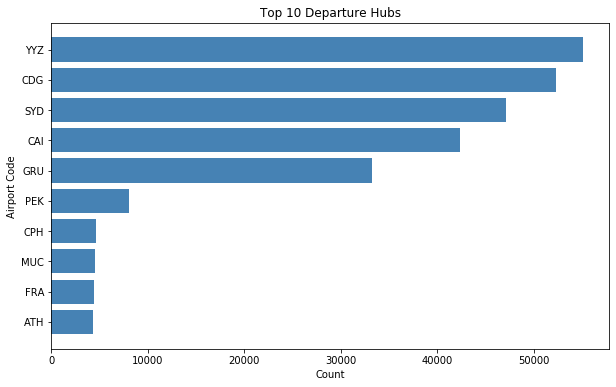

In [11]:
import matplotlib.pyplot as plt

# Get top 10 airports by count
top_airports = reduced_dep_rdd.takeOrdered(10, key=lambda x: -x[1])  

airport_codes = [a[0] for a in top_airports]
airport_counts = [a[1] for a in top_airports]

# Creating the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(airport_codes, airport_counts, color='steelblue')
plt.xlabel('Count')
plt.ylabel('Airport Code')
plt.title('Top 10 Departure Hubs')
plt.gca().invert_yaxis() 
plt.show()

In [12]:
reduced_dep_rdd.count() # 31 different airports in departure column

31

### 1.4. How many arriving flights per airport?

In [13]:
# Mapping each row to a tuple of (arrival airport code, 1)
mapped_arr_rdd = flights_rdd.map(lambda row: (row["Arrival Airport Code"], 1))

# Reducing by key to sum up the counts for each airport code
reduced_arr_rdd = mapped_arr_rdd.reduceByKey(lambda x, y: x + y)

for row in reduced_arr_rdd.collect():
    print(row)

('GRU', 14470)
('YYZ', 19260)
('CDG', 17342)
('SYD', 16905)
('PEK', 2410)
('MEL', 4009)
('CTU', 136)
('DUB', 3945)
('NBO', 2864)
('AEP', 2593)
('VCP', 900)
('CAN', 342)
('PTY', 3119)
('LIS', 4025)
('SZX', 161)
('CPH', 4375)
('JNB', 2318)
('MUC', 4426)
('BOG', 3520)
('CGK', 2714)
('NRT', 2852)
('LAX', 4278)
('IAH', 4422)
('HND', 2898)
('SFO', 4203)
('KUL', 2840)
('SIN', 3475)
('LIM', 3086)
('TPE', 2306)
('DME', 892)
('SAW', 717)
('CPT', 2555)
('LGW', 3541)
('ORD', 4270)
('LHR', 4874)
('ATL', 3528)
('CLT', 3871)
('PHX', 3925)
('SEA', 3473)
('FLL', 3866)
('SGN', 2147)
('CAI', 13817)
('ALG', 2009)
('VIE', 4242)
('CNF', 3746)
('SCL', 3208)
('BRU', 4163)
('XIY', 270)
('SHA', 521)
('CGO', 187)
('HGH', 256)
('PVG', 428)
('ADD', 2257)
('BOM', 3864)
('DEL', 4094)
('FRA', 4579)
('MXP', 4712)
('ATH', 4160)
('CMN', 1980)
('MEX', 3874)
('BLR', 4076)
('OSL', 3989)
('MNL', 2939)
('SVO', 1033)
('FCO', 4482)
('AMS', 4118)
('MAD', 4108)
('ICN', 2883)
('BKK', 3383)
('DXB', 3533)
('DOH', 3112)
('MAN', 4122

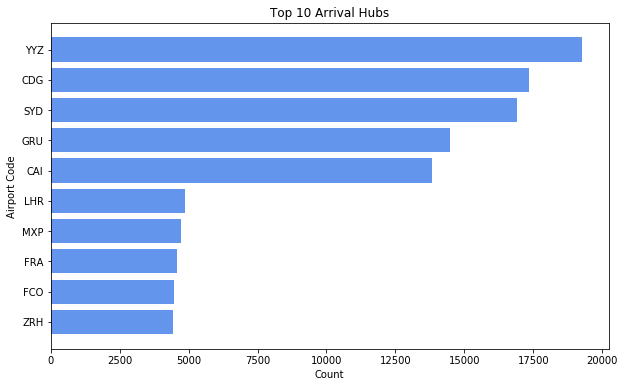

In [14]:
import matplotlib.pyplot as plt

# Get top 10 airports by count
top_airports = reduced_arr_rdd.takeOrdered(10, key=lambda x: -x[1])  

airport_codes = [a[0] for a in top_airports]
airport_counts = [a[1] for a in top_airports]

# Horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(airport_codes, airport_counts, color='cornflowerblue')
plt.xlabel('Count')
plt.ylabel('Airport Code')
plt.title('Top 10 Arrival Hubs')
plt.gca().invert_yaxis()
plt.show()

In [15]:
reduced_arr_rdd.count() # 78 different airports

78

### 1.5. Distribution of stops

In [16]:
# Mapping each row to a tuple of (departure airport code, 1)
mapped_stops_rdd = flights_rdd.map(lambda row: (row["Stops"], 1))

# Reducing by key to sum up the counts for each airport code
reduced_stops_rdd = mapped_stops_rdd.reduceByKey(lambda x, y: x + y)

# Displaying the result
for row in reduced_stops_rdd.collect():
    print(row)

(2, 156597)
(4, 637)
(0, 5426)
(6, 1)
(1, 130204)
(3, 13116)
(5, 34)


In [17]:
import matplotlib.pyplot as plt

# Extracting data for plotting
stops_count = [row[0] for row in reduced_stops_rdd.collect()]
count = [row[1] for row in reduced_stops_rdd.collect()]

### 1.6. Finding the most popular routes

In [18]:
# Mapping each row to a tuple of ((departure airport code, arrival airport code), 1)
mapped_rdd = flights_rdd.map(lambda row: ((row["Departure Airport Code"], row["Arrival Airport Code"]), 1))

# Reducing by key to sum up the counts for each combination of departure and arrival airport codes
reduced_rdd = mapped_rdd.reduceByKey(lambda x, y: x + y)

# Sorting the result by the count in descending order
sorted_rdd = reduced_rdd.sortBy(lambda x: x[1], ascending=False)


for row in sorted_rdd.collect()[:10]:
    print(row)

(('CDG', 'ZRH'), 1159)
(('CDG', 'FCO'), 1158)
(('CDG', 'AMS'), 1157)
(('CDG', 'CPH'), 1152)
(('CDG', 'MXP'), 1138)
(('CDG', 'LHR'), 1129)
(('YYZ', 'IAH'), 1127)
(('MUC', 'CDG'), 1118)
(('YYZ', 'MXP'), 1117)
(('CDG', 'ATH'), 1111)


### 1.7. Emission exploration

In [19]:
# check schema
flight_data.printSchema()

root
 |-- Departure Airport Code: string (nullable = true)
 |-- Departure Country: string (nullable = true)
 |-- Arrival Airport Code: string (nullable = true)
 |-- Arrival Country: string (nullable = true)
 |-- Aircraft Type: string (nullable = true)
 |-- Airline Number: string (nullable = true)
 |-- Airline Name: string (nullable = true)
 |-- Flight Number: string (nullable = true)
 |-- Departure Time: timestamp (nullable = true)
 |-- Arrival Time: timestamp (nullable = true)
 |-- Duration: long (nullable = true)
 |-- Stops: long (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Actual CO2 Emissions: integer (nullable = true)
 |-- Average CO2 Emissions: integer (nullable = true)
 |-- CO2 % Difference: integer (nullable = true)
 |-- Scan Date: timestamp (nullable = true)



#### 1.7.1 Average emissions by airline combinations

In [20]:
import pyspark.sql.functions as sqlfunc

# Grouping by the airline name and calculating the average actual CO2 emissions
co2_airlines = (flight_data
                .groupBy("Airline Name")
                .agg(sqlfunc.avg('Actual CO2 Emissions').alias('Average Emissions'))
                .orderBy('Average Emissions', ascending=False)
               )
co2_airlines.show()

+--------------------+-----------------+
|        Airline Name|Average Emissions|
+--------------------+-----------------+
|[Lufthansa| Singa...|         1.0472E7|
|[China Eastern| J...|        9831000.0|
|[China Eastern| D...|9235666.666666666|
|[LATAM| ANA| Shen...|        8979000.0|
|[American| ANA| JAL]|        8967000.0|
|[British Airways|...|        8955000.0|
|[Lufthansa| Briti...|        8947000.0|
|[LATAM| Alaska| U...|        8875000.0|
|[Qantas| Avianca|...|        8532000.0|
|[LATAM| American|...|        8522000.0|
|[American| Cathay...|8438333.333333334|
|     [ITA| Emirates]|        8361750.0|
|[Delta| Korean Ai...|        8361000.0|
|[Qantas| British ...|        8267000.0|
|[United| Delta| ANA]|        8217000.0|
|[Cathay Pacific| ...|        8049000.0|
|[Qantas| Aeromexi...|7951666.666666667|
|[China Eastern| A...|        7911000.0|
|[Shanghai Airline...|        7903000.0|
|[LATAM| Aeromexic...|        7894400.0|
+--------------------+-----------------+
only showing top

#### 1.7.2. Emissions by flight route

In [21]:
flight_data.printSchema()

root
 |-- Departure Airport Code: string (nullable = true)
 |-- Departure Country: string (nullable = true)
 |-- Arrival Airport Code: string (nullable = true)
 |-- Arrival Country: string (nullable = true)
 |-- Aircraft Type: string (nullable = true)
 |-- Airline Number: string (nullable = true)
 |-- Airline Name: string (nullable = true)
 |-- Flight Number: string (nullable = true)
 |-- Departure Time: timestamp (nullable = true)
 |-- Arrival Time: timestamp (nullable = true)
 |-- Duration: long (nullable = true)
 |-- Stops: long (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Actual CO2 Emissions: integer (nullable = true)
 |-- Average CO2 Emissions: integer (nullable = true)
 |-- CO2 % Difference: integer (nullable = true)
 |-- Scan Date: timestamp (nullable = true)



In [22]:
import pyspark.sql.functions as sqlfunc

# Group by "Departure Country" and "Arrival Country", calculate the average CO2 emissions,
# and order the result in descending order based on the average emissions
co2_airlines = (flight_data
                .groupBy("Departure Airport Code", "Arrival Airport Code")
                .agg(sqlfunc.avg('Actual CO2 Emissions').alias('Average Emissions'))
                .orderBy('Average Emissions', ascending=False)
               )

# Add the "Duration" column from flight_data divided by 60
co2_airlines = (co2_airlines
                .join(flight_data.groupBy("Departure Airport Code", "Arrival Airport Code").agg(sqlfunc.avg('Duration').alias('Average Duration')), ["Departure Airport Code", "Arrival Airport Code"], "left")
                .select("Departure Airport Code", "Arrival Airport Code", sqlfunc.round((sqlfunc.col("Average Duration") / 60), 2).alias("Average Duration (in hours)"), sqlfunc.round((sqlfunc.col("Average Emissions") / 1000000), 2).alias("Average Emissions (in millions)"))
               )

co2_airlines.show()


+----------------------+--------------------+---------------------------+-------------------------------+
|Departure Airport Code|Arrival Airport Code|Average Duration (in hours)|Average Emissions (in millions)|
+----------------------+--------------------+---------------------------+-------------------------------+
|                   CDG|                 MNL|                      27.35|                           1.92|
|                   YYZ|                 AEP|                      27.13|                            1.1|
|                   BOM|                 YYZ|                      28.26|                           1.65|
|                   CDG|                 SAW|                      14.47|                           0.34|
|                   CAI|                 IAH|                      25.76|                           1.25|
|                   GRU|                 CPH|                      23.27|                           1.61|
|                   GRU|                 LIM| 

#### 1.7.3. Emissions by number of stops

In [23]:
import pyspark.sql.functions as sqlfunc

# Grouping flights by the number of stops and calculate the average CO2 emissions
co2_stops = (flight_data
             .groupBy("Stops")
             .agg(sqlfunc.avg('Actual CO2 Emissions').alias('Average Emissions'))
            )

# Rounding the emissions to millions
co2_stops = co2_stops.withColumn('Average Emissions (in millions)', sqlfunc.round(co2_stops['Average Emissions'] / 1000000, 2))


co2_stops.show()

+-----+------------------+-------------------------------+
|Stops| Average Emissions|Average Emissions (in millions)|
+-----+------------------+-------------------------------+
|    0|305051.10164784297|                           0.31|
|    6|         2318000.0|                           2.32|
|    5|1366117.6470588236|                           1.37|
|    1| 817375.2814707424|                           0.82|
|    3|1945717.8084302999|                           1.95|
|    2|1427445.6005747863|                           1.43|
|    4|1787894.6540880504|                           1.79|
+-----+------------------+-------------------------------+



#### 1.7.4. Correlation matrix

https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame

In [45]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import pandas as pd
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, Imputer

# Ensure all selected columns are converted to DoubleType to avoid type issues
selected_columns = ['Actual CO2 emissions', 'Price', 'Duration', 'Stops']
for column in selected_columns:
    flight_data = flight_data.withColumn(column, col(column).cast(DoubleType()))

# Filter the DataFrame to select only the relevant columns
flight_selected = flight_data.select(selected_columns)

# Replace null values with the mean of the respective column
imputer = Imputer(strategy='mean', inputCols=flight_selected.columns, outputCols=flight_selected.columns)
flight_imputed = imputer.fit(flight_selected).transform(flight_selected)

# Convert selected columns to a vector column
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=flight_imputed.columns, outputCol=vector_col)
flight_vector = assembler.transform(flight_imputed).select(vector_col)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(flight_vector, vector_col)

# Extract and convert the correlation matrix
correlation_matrix_df = correlation_matrix.collect()[0]["pearson({})".format(vector_col)].toArray()
correlation_matrix_pd = pd.DataFrame(correlation_matrix_df, columns=selected_columns, index=selected_columns)

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix_pd)


Correlation Matrix:
                      Actual CO2 emissions     Price  Duration     Stops
Actual CO2 emissions              1.000000  0.680455  0.506812  0.360248
Price                             0.680455  1.000000  0.399977  0.312155
Duration                          0.506812  0.399977  1.000000  0.516075
Stops                             0.360248  0.312155  0.516075  1.000000


## 2. NETWORK MODELLING

### 2.1 Loading the data

In [46]:
# resetting the schema for the network
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, TimestampType, LongType, DoubleType, FloatType, DecimalType

# defining the schema for the network data
schema_net = StructType([
    StructField("Departure Airport Code", StringType(), True), 
    StructField("Departure Country", StringType(), True), 
    StructField("Arrival Airport Code", StringType(), True), 
    StructField("Arrival Country", StringType(), True), 
    StructField("Aircraft Type", StringType(), True), 
    StructField("Airline Number", StringType(), True), 
    StructField("Airline Name", StringType(), True), 
    StructField("Flight Number", StringType(), True), 
    StructField("Departure Time", TimestampType(), True), 
    StructField("Arrival Time", TimestampType(), True), 
    StructField("Duration", LongType(), True), 
    StructField("Stops", LongType(), True), 
    StructField("Price", StringType(), True), 
    StructField("Currency", StringType(), True), 
    StructField("Actual CO2 Emissions", StringType(), True), 
    StructField("Average CO2 Emissions", StringType(), True), 
    StructField("CO2 % Difference", StringType(), True), 
    StructField("Scan Date", TimestampType(), True)
])
   

In [47]:
# setting a new path for the network 
flights_path_net = "gs://selected-flights-bucket/selected_flights.csv"

flight_data_net = spark.read.csv(flights_path_net, header=True, schema=schema_net)

### 2.2. Emission Calculations

In [48]:
# adding the emissions per minute to the dataframe 
from pyspark.sql.functions import col, round

# Calculate emissions per minute
emissions_per_minute = (col("Actual CO2 Emissions") / col("Duration")) / 60

# Add the calculated emissions per minute as a new column
flight_data_net = flight_data_net.withColumn("Actual Emissions Per Minute", round(emissions_per_minute, 2))


In [49]:
import pyspark.sql.functions as F

# Aggregate average CO2 emissions for each airport pair
avg_co2_emissions = flight_data_net.groupBy(
    col("Departure Airport Code"), 
    col("Arrival Airport Code")
).agg(
    F.avg("Actual CO2 Emissions").alias("Average CO2 Emissions")
)

# Show some of the results to verify
avg_co2_emissions.show()

+----------------------+--------------------+---------------------+
|Departure Airport Code|Arrival Airport Code|Average CO2 Emissions|
+----------------------+--------------------+---------------------+
|                   YYZ|                 AEP|   1103667.2051696284|
|                   CDG|                 MNL|   1920181.9699499165|
|                   CDG|                 SAW|   335077.51937984495|
|                   BOM|                 YYZ|   1651724.9154453212|
|                   VIE|                 CDG|   231787.27841501564|
|                   GRU|                 CPH|    1607263.274336283|
|                   GRU|                 LIM|    686284.7222222222|
|                   YYZ|                 SAW|    1010846.547314578|
|                   CAI|                 IAH|   1248921.0526315789|
|                   XIY|                 CDG|   1187369.5652173914|
|                   CAI|                 MEX|    1419819.397993311|
|                   CAI|                 MNL|   

### 2.3. Creating the Network

In [50]:
from pyspark.sql.functions import col
from pyspark.sql.functions import avg
from graphframes import GraphFrame


# Create Vertices DataFrame
vertices = flight_data_net.select(col("Departure Airport Code").alias("id")).distinct() \
            .union(flight_data_net.select(col("Arrival Airport Code").alias("id")).distinct())

# Add CO2 emissions to edges DataFrame if not already included
edges = flight_data_net.select(
    col("Departure Airport Code").alias("src"),
    col("Arrival Airport Code").alias("dst"),
    col("Flight Number").alias("relationship"),
    col("Actual Emissions Per Minute").alias("weight")
)

# Create GraphFrame
g = GraphFrame(vertices, edges)

# Calculate in-degree centrality (number of incoming edges)
inDegrees = g.inDegrees

# Calculate average CO2 emissions for each edge
avg_co2_emissions = edges.groupBy("src", "dst").agg(avg("weight").alias("avg_weight"))

# Join this data back to the edges DataFrame if necessary
edges = edges.join(avg_co2_emissions, ["src", "dst"], "left")


In [51]:
from graphframes import GraphFrame

# Compute in-degree centrality (the number of incoming edges per node)
in_degrees = g.inDegrees

# Convert the GraphFrame vertices and edges to Pandas DataFrames
vertex_pd = g.vertices.toPandas()
in_degrees_pd = in_degrees.toPandas()

In [52]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import FloatType

# Ensure 'weight' is a float
edges = edges.withColumn('weight', col('weight').cast(FloatType()))

# Handle any potential non-numeric values that can't be converted to float
edges = edges.withColumn('weight', when(col('weight').isNull(), 0).otherwise(col('weight')))

# Now convert to Pandas DataFrame
edge_pd = edges.toPandas()

### 2.4. Plotting the Network 

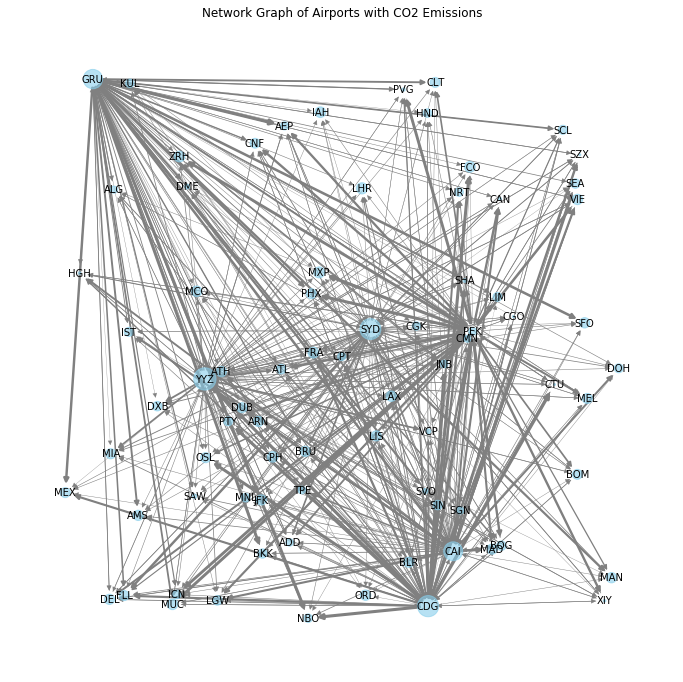

In [53]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# https://networkx.org/documentation/stable/tutorial.html 
# Generate node sizes directly indexed by node IDs if `in_degrees` DataFrame is indexed by node IDs
node_size_dict = dict(zip(in_degrees_pd['id'], in_degrees_pd['inDegree']))
max_degree = max(node_size_dict.values())
node_sizes = {node: 500 * (degree / max_degree) for node, degree in node_size_dict.items()}

# Create the graph
G = nx.DiGraph()

# Add nodes with sizes based on in-degree centrality
for idx, row in vertex_pd.iterrows():
    # Use the node ID to fetch the correct size
    node_id = row['id']
    node_size = node_sizes.get(node_id, 100)  # Default size if not found
    G.add_node(node_id, size=node_size)

# Normalize edge weights (CO2 emissions for visualization)
max_emission = edge_pd['weight'].max()
edge_weights = [5 * weight / max_emission for weight in edge_pd['weight']]

# Add edges with normalized weights
for idx, row in edge_pd.iterrows():
    G.add_edge(row['src'], row['dst'], weight=edge_weights[idx])

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.random_layout(G)  # Position nodes using a layout

nx.draw_networkx_nodes(G, pos, node_size=[v['size'] for v in G.nodes.values()], node_color='skyblue', alpha=0.6)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=edge_weights)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Network Graph of Airports with CO2 Emissions')
plt.axis('off')  
plt.show()


### 2.5. Community Detection 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

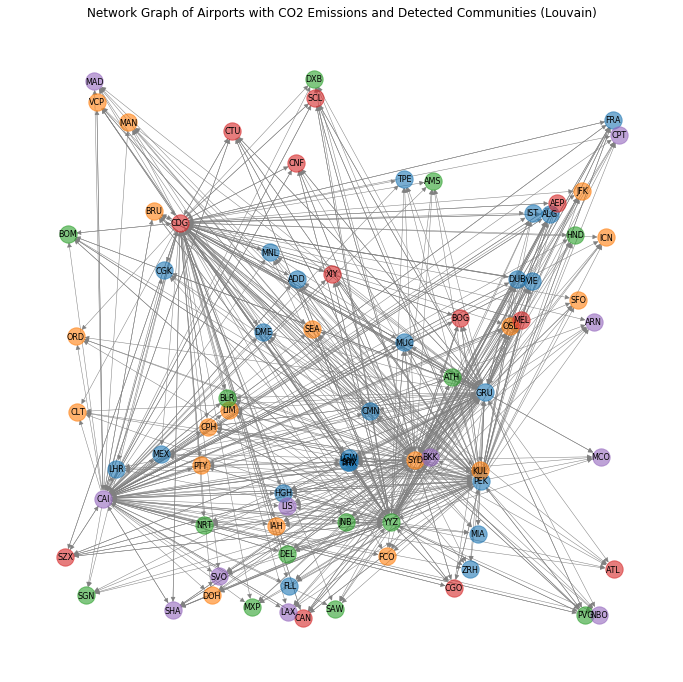

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html

# Perform community detection using the Louvain algorithm
communities = nx.algorithms.community.greedy_modularity_communities(G, weight='weight')

# Plot the graph with communities
plt.figure(figsize=(12, 12))
pos = nx.random_layout(G)  # Position nodes using a layout

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=plt.cm.tab10(i), alpha=0.6)
    nx.draw_networkx_labels(G, pos, labels={node: node for node in community}, font_size=8)

nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5)

plt.title('Network Graph of Airports with CO2 Emissions and Detected Communities (Louvain)')
plt.axis('off')  # Turn off the axis
plt.show()


In [12]:
import pandas as pd

# Create a dictionary mapping airports to clusters
airport_cluster_mapping = {}
for i, community in enumerate(communities):
    for airport in community:
        airport_cluster_mapping[airport] = i + 1  # Add 1 to cluster ID to match indexing starting from 1

# Convert the dictionary to a DataFrame
df_airport_clusters = pd.DataFrame(list(airport_cluster_mapping.items()), columns=['Airport', 'Cluster'])

# Print the DataFrame
print(df_airport_clusters)


   Airport  Cluster
0      GRU        1
1      VIE        1
2      DME        1
3      CMN        1
4      IST        1
..     ...      ...
73     BKK        5
74     CAI        5
75     LAX        5
76     ARN        5
77     LIS        5

[78 rows x 2 columns]
